In [1]:
# Setup - import library and load data from local file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

In [2]:
# We don't want fuzzy figures. Set to higher quality sharp images please
plt.rcParams['figure.dpi'] = 150 # big enough to be good but not hog the screen, in-notebook
plt.rcParams['savefig.dpi'] = 300 # for publication

#This file was downloaded from the survey completed by participants on the Manchester Select Survey online survey tool. 
backgrounds = pd.read_csv("data/background_survey.csv")

#take a peek into the file
backgrounds.head()

,Respondent ID,Date Started,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,years_experience_computer
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,15
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,2
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,17
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,9
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",18


In [3]:
#rename some badly named columns from the survey. Oopsie.

columns_to_rename = {
    "Any biological software tools you'd like to add to the list? How often do you use it?" : "software_tools_freetext",
    "years_experience" : "biology_years_experience",
    "years_experience.1" : "computer_years_experience",
    "What file types do you commonly use for biological data? " : "bio_file_types",
    "biological_education.1" : "computer_education"
}

backgrounds = backgrounds.rename(columns = columns_to_rename )

backgrounds.bio_file_types

0                               GFF;FASTA;BAM;CSV / TSV
1                        mzml and imzml;FASTA;CSV / TSV
2     GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...
3     FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...
4     JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...
5     GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...
6     Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...
7                           GFF;FASTA;VCF;BAM;CSV / TSV
8                                      Phylip;FASTA;PDB
9     I have not actively done research in the last ...
10    tab;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...
11    CRAM;FASTA;VCF;BAM;CSV / TSV;Excel / Google Sh...
12    FASTQ, CRAM/CRAI, LOOM, MTX, HD5;GFF;FASTA;VCF...
13    use/look at JSON & XML;FASTA;CSV / TSV;Excel /...
14    FASTA;CSV / TSV;Excel / Google Sheets / other ...
15                                     binary;CSV / TSV
16    FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...
17    FASTA;VCF;CSV / TSV;Excel / Google Sheets 

Some columns in the sheet above have multi-choice answers aggregated to the same column. We need to split them out into separate so that we can query the data. 

In [4]:
#"split a multi choice answer, returning a series with a column 
# header and the responses with the header stripped out."
def split_multi_choice( a_series, series_prefix ):
    # variable to store the final response in as we build it
    response = list()
    # Multi-choice answer sets are separated by ; in SelectSurvey
    series_as_df = a_series.str.split(";",expand=True)
    # extract the name of each column and throw it out, 
    # as it's recorded once per row, which is a bit excessive - 
    # we can just keep it as a column header instead
    for i in series_as_df:
        answer = series_as_df[i]
        split_answer = pd.DataFrame(answer.str.split("=",expand=True))
        
        series_name = series_prefix + "_" + split_answer[0][0] # the 0th value of this is the same for every column
        series_content = split_answer[1]
        
        # add the split responses in to a single column
        returnSeries = pd.Series(data=series_content, name=series_name)
        
        # glue the column into the object we'll be returning
        response.append(returnSeries)
    return pd.DataFrame(response).transpose()


In [5]:
# computationally split-out-able vars: 
bio_software = split_multi_choice(backgrounds.bio_database_experience, "bio_software")
computer_experience = split_multi_choice(backgrounds.computer_experience, "computer_experience")

In [6]:
# re-append these two split-out columns into the dataframe
expanded_backgrounds = backgrounds.join([bio_software, computer_experience])

# Preview hte data now...
expanded_backgrounds.head()

,Respondent ID,Date Started,biological_education,bio_database_experience,software_tools_freetext,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,bio_file_types,...,computer_experience_python,computer_experience_perl,computer_experience_java,computer_experience_rdbm,computer_experience_functional_language,computer_experience_graph_db,computer_experience_semantic,computer_experience_html,computer_experience_js,computer_experience_git
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day


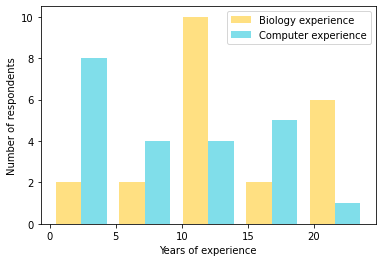

In [7]:
#Exploring the data - what does people's experience look like in a histogram? 

xp_hist = [expanded_backgrounds["years_experience_bio"], expanded_backgrounds["years_experience_computer"]]

plt.hist(xp_hist, bins=5,histtype="bar",color=['#FFE082','#80DEEA'])
plt.xlabel("Years of experience")
plt.ylabel("Number of respondents")
plt.legend(["Biology experience", "Computer experience"])
plt.savefig('figures/bio_computer_xp_years_bar.png',dpi=300)

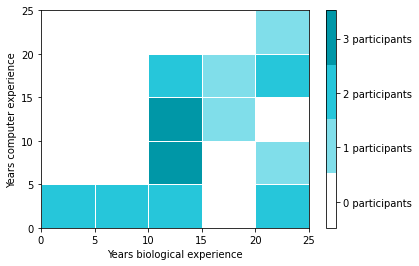

In [18]:
#Heatmap might be more useful than the above diagram
#This is the Figure 1 shown in the paper

color_scale = ['#FFFFFF', '#80DEEA','#26C6DA', '#0097A7']
#color_scale = ['#FFA000','#FFCA28','#FFE082','#0097A7','#26C6DA','#80DEEA']
my_colors_4 = colors.ListedColormap(color_scale)

fig = plt.hist2d(expanded_backgrounds["years_experience_bio"], 
                 expanded_backgrounds["years_experience_computer"], 
                 bins=5, 
                 range=[[0,25], [0,25]], density=False, 
                 cmap=my_colors_4,
                 color='w')

my_ticks = [0,1,2,3]
norm = colors.BoundaryNorm(my_ticks, 4)

def tick_to_show(x, pos):
    if(pos in my_ticks):
        return str(pos) + " participants"

fmt = ticker.FuncFormatter(tick_to_show)

colorbar = plt.colorbar(None, ticks=[-0.4,0.85,2.1,3.35], format=fmt, norm=norm)

plt.clim(-1,4)

plt.xlabel('Years biological experience')
plt.ylabel('Years computer experience')

plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])

plt.savefig('figures/figure1.png',dpi=300)

/Users/user/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


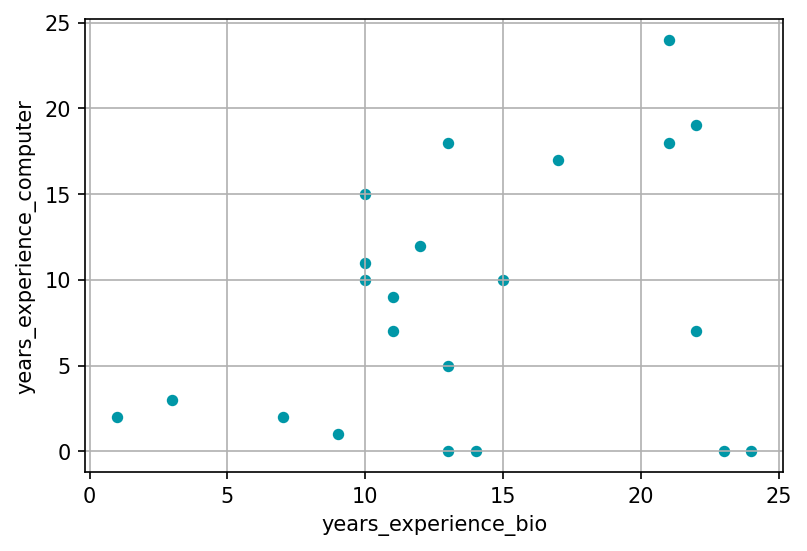

In [24]:
#bio xp (years) vs computer xp (years)
scatterplt = expanded_backgrounds.drop(["Respondent ID"], axis=1)
scatterplt = scatterplt.plot.scatter(x="years_experience_bio", 
                        y="years_experience_computer", 
                        color='#0097A7')
scatterplt.grid(True)
scatterplt.figure.savefig('figures/bio_comp_xp_years_scatterplot.png')

### Formal education levels

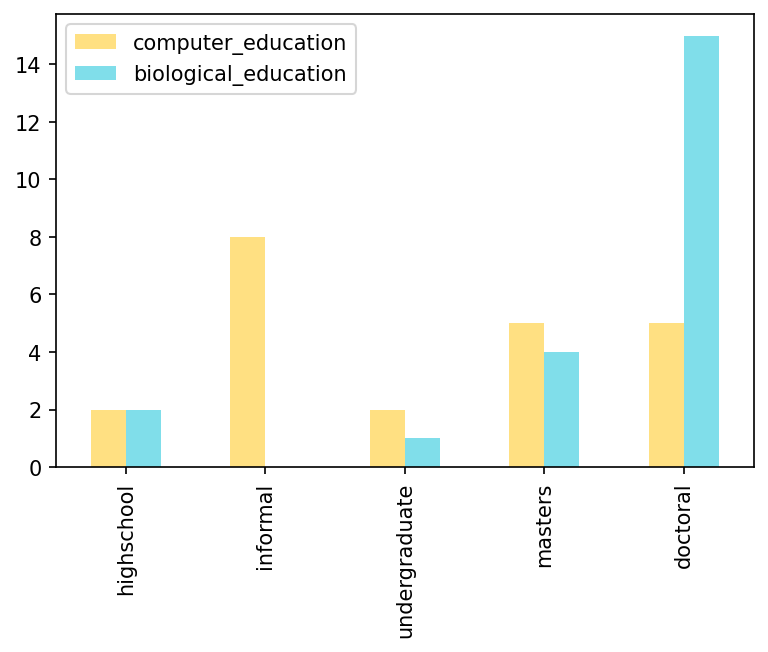

In [25]:
# bio xp (formal education) vs computer xp (formal education)

# First, set up the data categories
degree_order = ["highschool", "informal", "undergraduate", "masters", "doctoral"]

# add category datatypes and make sure it's ordinal
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].astype("category")
expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].astype("category")

expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].cat.set_categories(degree_order, ordered=True)
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].cat.set_categories(degree_order, ordered=True)

#we want to just get the counts of who has which level. 
computer_formal = expanded_backgrounds["computer_education"].value_counts()
bio_formal = expanded_backgrounds["biological_education"].value_counts()

# in order to plot this as a bar chart, we want a df 
# with the categories as the labels and the values as rows
both_formal = pd.DataFrame([computer_formal, bio_formal])

# order based on the degree classification
both_formal = both_formal.T.sort_index()

#visualise
barchart = both_formal.plot.bar(color=['#FFE082','#80DEEA'])
barchart.figure.savefig('figures/bio_computer_formal_bar.png',dpi=300)

In [11]:
# convert the formal education levels to a number in order to fake a plot...
# there might be a better way to do this? 
levels = {
    "highschool" : 1, 
    "informal" : 2, 
    "undergraduate" : 3, 
    "masters": 4, 
    "doctoral": 5
}


bio_numberwise = expanded_backgrounds["biological_education"]
computer_numberwise = expanded_backgrounds["computer_education"]

bio_numberwise = bio_numberwise.map(levels)
computer_numberwise = computer_numberwise.map(levels)


# Background - bio vs computing

In [12]:
formal_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
formal_scatter_data = formal_scatter_data.transpose()

## Years of experience

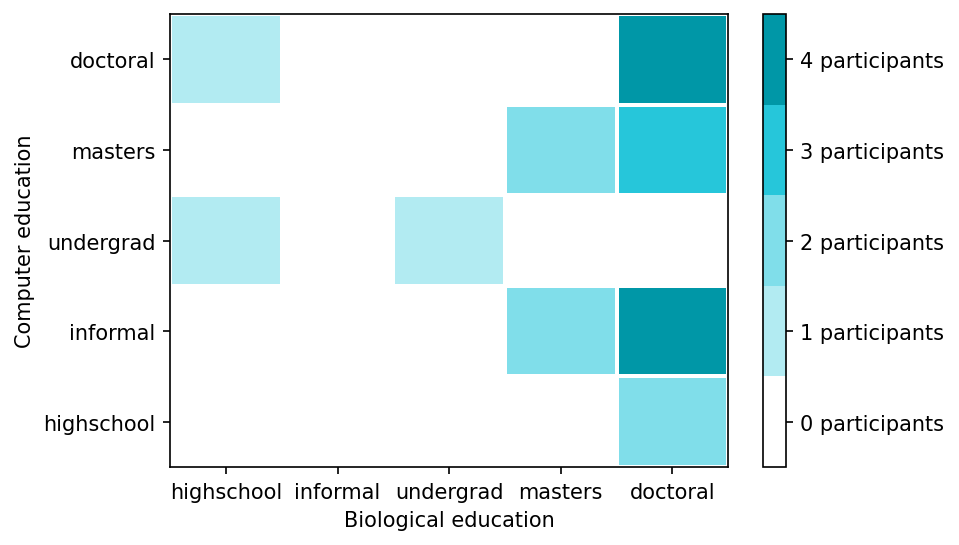

In [26]:
#visualise a heatmap of formal experience bio vs computational

xp_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
xpx1_scatter_data = formal_scatter_data.transpose()

degreescale = ("highschool",
    "informal", 
    "undergrad", 
    "masters",
    "doctoral")

color_scale = ['#FFFFFF','#B2EBF2', '#80DEEA','#26C6DA', '#0097A7']

#color_scale = ['#FFA000','#FFCA28','#FFE082','#0097A7','#26C6DA','#80DEEA']
my_colors_5 = colors.ListedColormap(color_scale)

plt.hist2d(formal_scatter_data["biological_education"], 
           formal_scatter_data["computer_education"], 
           bins=5, 
           color=['w'],
           cmap=my_colors_5)
plt.xlabel('Biological education')
plt.ylabel('Computer education')

## This is a very hacky way to get the labels perfect 😬
plt.xticks([1.4,2.2,3,3.8,4.6], degreescale)
plt.yticks([1.4,2.2,3,3.8,4.6], degreescale)
my_ticks = (0,1,2,3,4)
tick_positions = [-0.4,0.8,2,3.2,4.4]
norm = colors.BoundaryNorm(my_ticks, 5)

def tick_to_show_5(x, pos):
    if(pos in my_ticks):
        return str(pos) + " participants"
fmt = ticker.FuncFormatter(tick_to_show_5)
plt.clim(-1,5)

plt.colorbar(None, 
             ticks=tick_positions, 
             format=fmt, 
             norm=norm)
plt.savefig('figures/bio_computer_formal.png',dpi=300)

In [30]:
frequency_of_use_order = [" every_day", " every_week", " every_month"," year_or_less", " heard_of"," never_heard"]

def graph_bg(bg_counts, graph_label, file_name):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries.
        Modified version of the pandas docs discrete hotizontal bar chart.
    graph_label : string
        A title for the graph. 
    file_name : string
        'nuff said. 
    """    
    temp_working_var = {}

    #format each column for the barchart
    for label, content in bg_counts.items():
        vals = content.value_counts()
        temp_working_var[label] = vals
    
    #there are too many datatype conversions here, but it works so I'm leaving it... 
    temp_working_var = pd.DataFrame(temp_working_var).copy()   
    temp_working_var = temp_working_var.fillna(0) #leaving NaNs makes everything break
    
    # it's easier to interpret when the values are sorted by commonly
    # used values first
    temp_working_var.sort_values(by=[" every_day", " every_week", " every_month"],
                                 axis=1,
                                 ascending=[False,False,False],
                                 inplace=True)

    results = temp_working_var.to_dict("list")
    labels = list(results.keys())
    data = np.array(list(results.values()),dtype="object")
    
    #this specifies the start position of each stacked bar
    data_cum = data.cumsum(axis=1)
    
    category_colors =  ['#0097A7','#26C6DA','#80DEEA','#FFE082','#FFCA28','#FFA000']

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(frequency_of_use_order, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        ax.bar_label(rects, label_type='center')
        
    ax.legend(ncols=len(frequency_of_use_order), bbox_to_anchor=(-0.035, 1),
              loc='lower left', fontsize='small')
    
    ax.set_title(graph_label, loc="center", pad=25)
    
    plt.savefig('figures/filetypes_' + file_name + '.png',dpi=300)


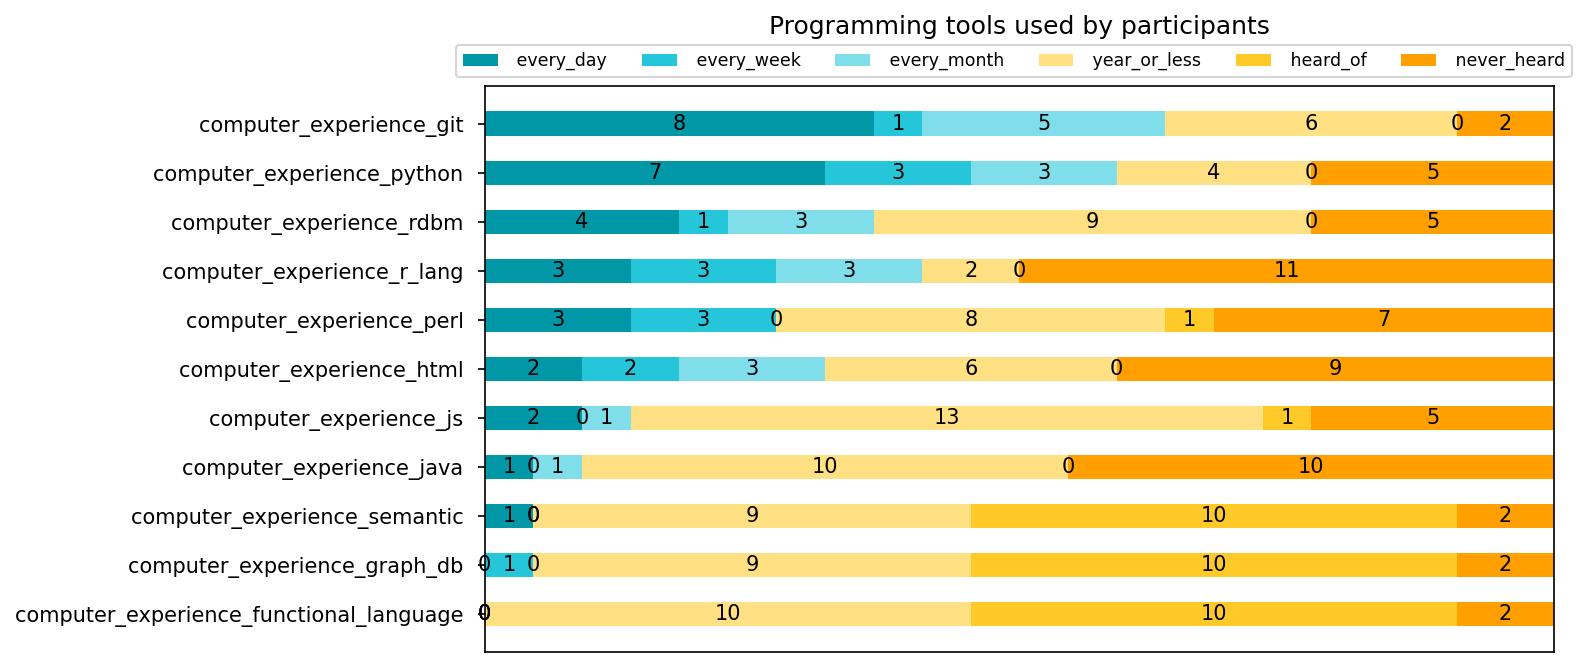

In [31]:
graph_bg(computer_experience, "Programming tools used by participants", "computer_experience")

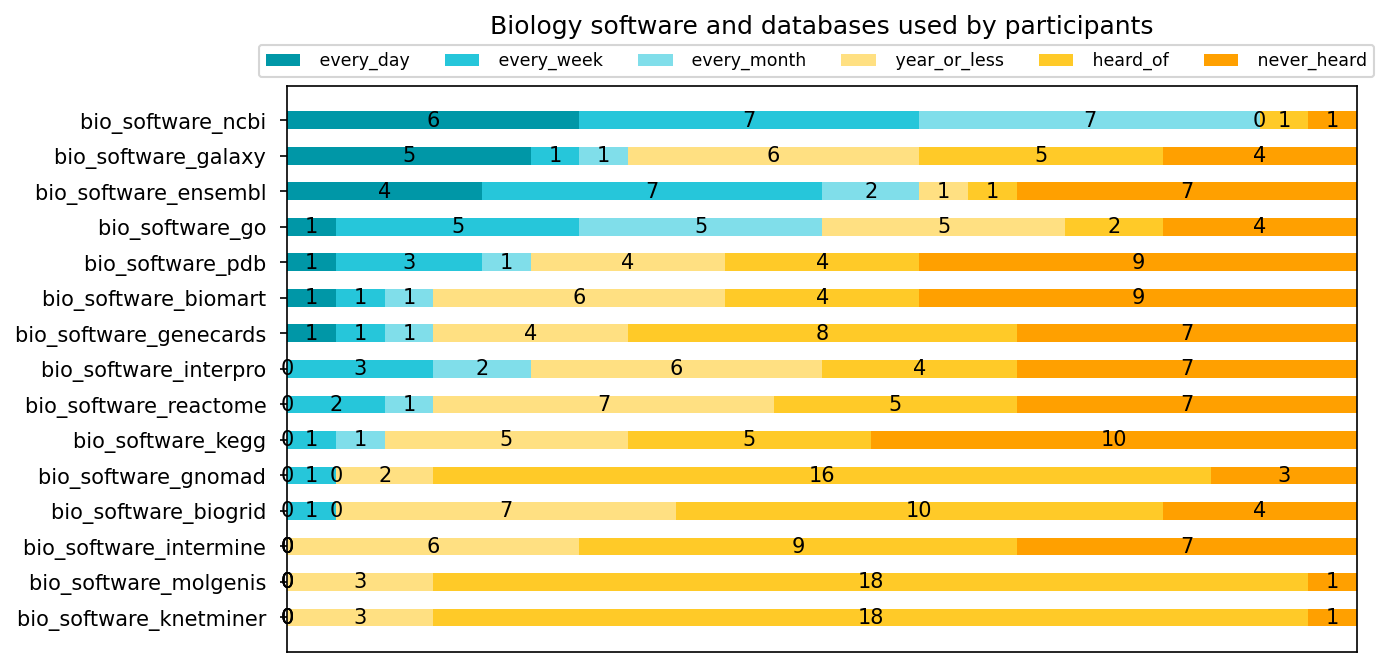

In [32]:
graph_bg(bio_software, "Biology software and databases used by participants", "bio_software")

In [17]:
# this column isn't key/value frequency pairs like the last two, so needs slightly different processing
# Multi-choice answer sets are separated by ; in SelectSurvey
bio_file_types = backgrounds.bio_file_types.str.split(";",expand=True)

common_types = ["GFF","FASTA","VCF", "BAM","CSV / TSV","PDB","Excel / Google Sheets / other spreadsheets"]

# get the count of individual answers
bio_file_types = bio_file_types.stack().value_counts()

# one entry for all the "other" types will be more interesting
# and easier to visualise too
other_types = bio_file_types.drop(common_types)

#sum up the count of "other" types. sum ensures that if there are two duplicate "other" types
## it'll get counted twice (unlike, say, length of series)
other_types = pd.Series(index=["Other"], data=other_types.sum())

bio_file_types = bio_file_types.filter(common_types)
bio_file_types = pd.concat([bio_file_types, other_types])

#take a peek, does it look right? 

bio_file_types.sort_values(inplace=True)

print(bio_file_types)

PDB                                            3
GFF                                           10
VCF                                           12
Other                                         12
BAM                                           14
Excel / Google Sheets / other spreadsheets    15
FASTA                                         21
CSV / TSV                                     21
dtype: int64


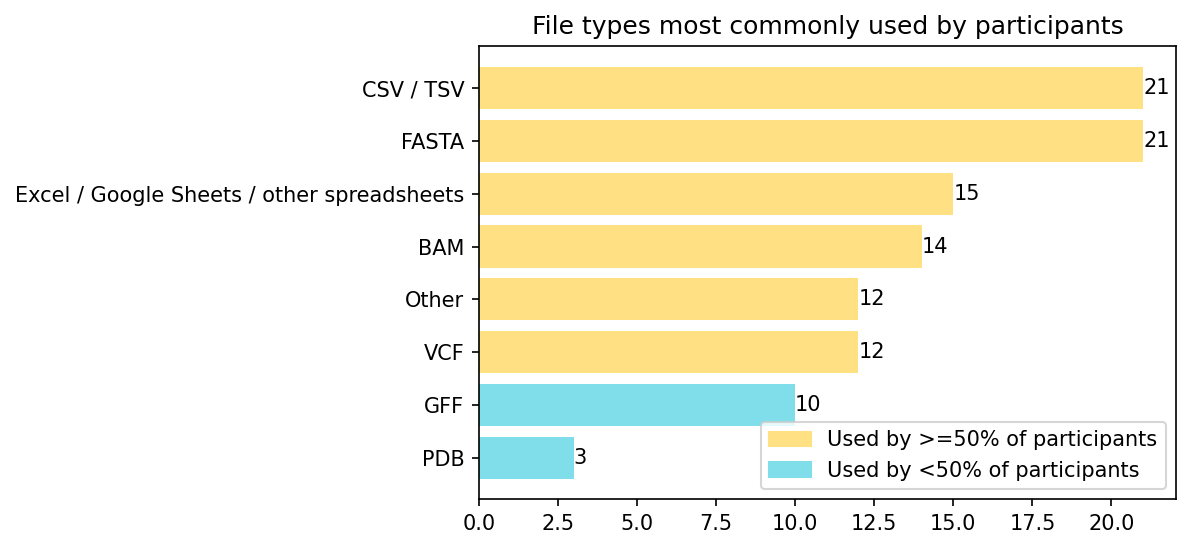

In [29]:
#okie, let's visualise the file type data. Standard Barchart is simplest. 
filefig, fileax = plt.subplots()


#colour items that the majority use differently than
# items used by a minority
high_color='#FFE082'
low_color='#80DEEA'
def bar_color(bar_val,max_val):
    if(bar_val >= max_val/2):
        return high_color
    else:
        return low_color

#create a legend for the colours
high_patch = mpatches.Patch(color=high_color, label='Used by >=50% of participants')
low_patch = mpatches.Patch(color=low_color, label='Used by <50% of participants')
fileax.legend(handles=[high_patch,low_patch])

fileax.set_title("File types most commonly used by participants")

#Set bar properties individually, such as colour and labels
for file_type, count in bio_file_types.items():
    color = bar_color(count,bio_file_types.max())
    p = fileax.barh(file_type, count, label=file_type,color=color)
    fileax.bar_label(p, label_type='edge')

plt.savefig('figures/bio_files_types_bar.png',dpi=300)

In [19]:
# add participant identifiers to file
# not sure if we need file names or participant identifiers, let's just build both and see what nvivo likes

# variable to store the final response in as we build it
file_name = list()
participant_id = list()
prefix = ""

id_col = expanded_backgrounds["Respondent ID"]

for i in id_col:
    print(i, id_col[i-1])
    val = id_col[i-1]
    if (val < 10):
        prefix = "0"
    else:
        prefix = ""
    val = str(val)
        
    file_name.append("Files\\\\" + prefix + val + "_transcription")
    participant_id.append("Participant " + val)


participant_id = pd.DataFrame(participant_id)

participant_labelled_data = participant_id.join(expanded_backgrounds)

participant_labelled_data.to_csv("data/expanded_bg.csv",index=False)


1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
